In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.applications.mobilenet import preprocess_input

from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from PIL import Image

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [5]:
#preprocess_fun = tf.keras.applications.mobilenet.preprocess_input

train_datagen = ImageDataGenerator(#horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0,
                                   #preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0,
                                  #preprocessing_function=preprocess_fun
                                 )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [6]:
#loading image data
# train_imagedata_preprocessed = np.load(r'FeatureFiles/MobileNet_train_imagedata_preprocessed.npy')
# print('Loaded train image data')
# test_imagedata_preprocessed = np.load(r'FeatureFiles/MobileNet_test_imagedata_preprocessed.npy')
# print('Loaded test image data')
train_lowfeatures = np.load(r'FeatureFiles/train_lowfeatures.npy')
print('Loaded train low features')
test_lowfeatures = np.load(r'FeatureFiles/test_lowfeatures.npy')
print('Loaded test low features')
train_semanticfeatures = np.load(r'FeatureFiles/train_semanticfeatures.npy')
print('Loaded train semantic features.')
test_semanticfeatures = np.load(r'FeatureFiles/test_semanticfeatures.npy')
print('Loaded test semantic features')

train_labels = np.load(r'FeatureFiles/train_labels.npy')
print('Loaded train labels')
test_labels = np.load(r'FeatureFiles/test_labels.npy')
print('Loaded test labels')

Loaded train low features
Loaded test low features
Loaded train semantic features.
Loaded test semantic features
Loaded train labels
Loaded test labels


In [6]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                #graph_def = tf.GraphDef.FromString(file_handle.read())
                #graph = tf.Graph()
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
            
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    def run(self, image):
        """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
        #width, height = image.shape[0], image.shape[1]
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        #resized_image = np.resize(image, target_size)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        
        return resized_image, seg_map
    
def create_ade20k_label_colormap():
        
    """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
    colormap = np.asarray([
        [0,0,0],
        [120, 120, 120],
        [180, 120, 120],
        [6, 230, 230],
        [80, 50, 50],
        [4, 200, 3],
        [120, 120, 80],
        [140, 140, 140],
        [204, 5, 255],
        [230, 230, 230],
        [4, 250, 7],
        [224, 5, 255],
        [235, 255, 7],
        [150, 5, 61],
        [120, 120, 70],
        [8, 255, 51],
        [255, 6, 82],
        [143, 255, 140],
        [204, 255, 4],
        [255, 51, 7],
        [204, 70, 3],
        [0, 102, 200],
        [61, 230, 250],
        [255, 6, 51],
        [11, 102, 255],
        [255, 7, 71],
        [255, 9, 224],
        [9, 7, 230],
        [220, 220, 220],
        [255, 9, 92],
        [112, 9, 255],
        [8, 255, 214],
        [7, 255, 224],
        [255, 184, 6],
        [10, 255, 71],
        [255, 41, 10],
        [7, 255, 255],
        [224, 255, 8],
        [102, 8, 255],
        [255, 61, 6],
        [255, 194, 7],
        [255, 122, 8],
        [0, 255, 20],
        [255, 8, 41],
        [255, 5, 153],
        [6, 51, 255],
        [235, 12, 255],
        [160, 150, 20],
        [0, 163, 255],
        [140, 140, 140],
        [250, 10, 15],
        [20, 255, 0],
        [31, 255, 0],
        [255, 31, 0],
        [255, 224, 0],
        [153, 255, 0],
        [0, 0, 255],
        [255, 71, 0],
        [0, 235, 255],
        [0, 173, 255],
        [31, 0, 255],
        [11, 200, 200],
        [255, 82, 0],
        [0, 255, 245],
        [0, 61, 255],
        [0, 255, 112],
        [0, 255, 133],
        [255, 0, 0],
        [255, 163, 0],
        [255, 102, 0],
        [194, 255, 0],
        [0, 143, 255],
        [51, 255, 0],
        [0, 82, 255],
        [0, 255, 41],
        [0, 255, 173],
        [10, 0, 255],
        [173, 255, 0],
        [0, 255, 153],
        [255, 92, 0],
        [255, 0, 255],
        [255, 0, 245],
        [255, 0, 102],
        [255, 173, 0],
        [255, 0, 20],
        [255, 184, 184],
        [0, 31, 255],
        [0, 255, 61],
        [0, 71, 255],
        [255, 0, 204],
        [0, 255, 194],
        [0, 255, 82],
        [0, 10, 255],
        [0, 112, 255],
        [51, 0, 255],
        [0, 194, 255],
        [0, 122, 255],
        [0, 255, 163],
        [255, 153, 0],
        [0, 255, 10],
        [255, 112, 0],
        [143, 255, 0],
        [82, 0, 255],
        [163, 255, 0],
        [255, 235, 0],
        [8, 184, 170],
        [133, 0, 255],
        [0, 255, 92],
        [184, 0, 255],
        [255, 0, 31],
        [0, 184, 255],
        [0, 214, 255],
        [255, 0, 112],
        [92, 255, 0],
        [0, 224, 255],
        [112, 224, 255],
        [70, 184, 160],
        [163, 0, 255],
        [153, 0, 255],
        [71, 255, 0],
        [255, 0, 163],
        [255, 204, 0],
        [255, 0, 143],
        [0, 255, 235],
        [133, 255, 0],
        [255, 0, 235],
        [245, 0, 255],
        [255, 0, 122],
        [255, 245, 0],
        [10, 190, 212],
        [214, 255, 0],
        [0, 204, 255],
        [20, 0, 255],
        [255, 255, 0],
        [0, 153, 255],
        [0, 41, 255],
        [0, 255, 204],
        [41, 0, 255],
        [41, 255, 0],
        [173, 0, 255],
        [0, 245, 255],
        [71, 0, 255],
        [122, 0, 255],
        [0, 255, 184],
        [0, 92, 255],
        [184, 255, 0],
        [0, 133, 255],
        [255, 214, 0],
        [25, 194, 194],
        [102, 255, 0],
        [92, 0, 255],
    ])
    return colormap

def label_to_color_image(label):
        """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the ADE20K color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
        if label.ndim != 2:
            raise ValueError('Expect 2-D input label')
        colormap = create_ade20k_label_colormap()
        
        if np.max(label) >= len(colormap):
            raise ValueError('label value too large.')
            
        return colormap[label]
    
def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1]) #分为 1行4列,

    plt.subplot(grid_spec[0])  # 4个图的第一部分
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
        
        
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()
        
    size = seg_image.shape[0] * seg_image.shape[1]
    selLABEL_NAMES = np.asarray([
                'tree', 'shrub', 'grass','road','sidewalk','sky','building'
                ])
    ratio_sum = ratio_plant = 0
    ratio_tree = ratio_shrub = ratio_grass = ratio_road = ratio_sidewalk = 0
        
    for m in seg_map.flatten():
        label = LABEL_NAMES[m]
        if label == 'tree':
            ratio_tree = ratio_tree+1
        if label == 'shrub':
            ratio_shrub = ratio_shrub+1
        if label == 'grass':
            ratio_grass = ratio_grass+1  
        if label == 'road':
            ratio_road = ratio_road+1 
        if label == 'sidewalk':
            ratio_sidewalk = ratio_sidewalk+1
                
        for n in selLABEL_NAMES:
            if label == n:
                ratio_sum = ratio_sum + 1
            
    ratio_tree_i = ratio_tree / len(seg_map.flatten())
    ratio_shrub_i = ratio_shrub / len(seg_map.flatten())
    ratio_grass_i = ratio_grass / len(seg_map.flatten())
    ratio_road_i = ratio_road / len(seg_map.flatten()) 
    ratio_sidewalk_i = ratio_sidewalk / len(seg_map.flatten()) 

    ratio_plant_i = (ratio_tree + ratio_shrub + ratio_grass)/ len(seg_map.flatten())
    #ratio_sum_i = ratio_sum / len(seg_map.flatten())
    print('tree合计占比为：',ratio_tree_i)
    print('shrub合计占比为：',ratio_shrub_i)
    print('grass合计占比为：',ratio_grass_i)
    print('road合计占比为：',ratio_road_i)
    print('sidewalk合计占比为：',ratio_sidewalk_i)
    print('plant经过计算植物合计占比为：',ratio_plant_i)
        
    return ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_plant_i, ratio_road_i ,ratio_sidewalk_i

LABEL_NAMES = np.asarray([
        'ignore', 'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 
         'bed', 'window', 'grass', 'cabinet', 'sidewalk', 'person', 'ground', 'door', 
        'table', 'mount', 'shrub', 'curtain', 'chair', 'car', 'water', 'picture', 
        'couch', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field', 'armchair',
        'seat', 'fence', 'desk', 'rock', 'clothes', 'lamp', 'bath', 'rail', 'cushion',
        'stand', 'box', 'pillar', 'signboard', 'drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'cupboard', 'path', 'steps',
        'runway', 'case', 'pool', 'pillow', 'screen', 'stairway', 'river', 
        'bridge', 'bookcase', 'blinds', 'coffeeTable', 'toilet', 'flower', 'book',
        'hill', 'bench', 'countertop', 'kitchen Sove', 'tree', 'kitchen', 
        'computingMachine', 'chair', 'boat', 'bar', 'machine', 'hut', 'bus', 
        'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight',
        'booth', 'displayMonitor', 'airplane', 'dirtTrack', 'apparel', 'pole', 
        'ground', 'handrail', 'escalator', 'ottoman', 'bottle', 'counter', 'poster', 
        'stage', 'van', 'ship', 'fountain', 'conveyor', 'canopy', 'washer', 'toy', 
        'swimmingPool', 'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 
        'bike', 'cradle', 'oven', 'ball', 'food', 'step', 'container', 'brandLogo', 
        'oven', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'projectorScreen', 
        'blanket', 'statue', 'hood', 'sconce', 'vase', 'trafficLight', 'tray', 
        'GarbageBin', 'fan', 'dock', 'computerMonitor', 'plate', 'monitoringDevice', 
        'bulletinBoard', 'shower', 'radiator', 'drinkingGlass', 'clock', 'flag'
     ])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
#print('FULL_LABEL_MAP',FULL_LABEL_MAP)

FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
#print('FULL_COLOR_MAP',FULL_COLOR_MAP)

In [7]:
MODEL_NAME = 'xception65_ade20k_train'  # @param ['mobilenetv2_ade20k_train', 'xception65_ade20k_train']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_ade20k_train':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'xception65_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
MODEL.INPUT_SIZE = 420

# Reduce image size if mobilenet model
if "mobilenetv2" in MODEL_NAME:
    MODEL.INPUT_SIZE = 257

print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


2022-07-29 01:30:30.785473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 01:30:30.785621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 01:30:30.827197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stud1/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-29 01:30:30.827207: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

In [18]:
def semantic_extractor(inputs, model):
    BATCH_SIZE = 128
    img_num = 0
    
    while img_num < BATCH_SIZE:
        img = inputs[img_num]*255
        img = img.astype(np.uint8)
        pil_img = Image.fromarray(img)
        
        resized_im, seg_map = model.run(pil_img)
        output_per_img = np.zeros(shape=(151,))
        for i in range(len(seg_map)):
            for j in range(len(seg_map[i])):
                output_per_img[seg_map[i][j]] += 1
        output_per_img = np.resize(output_per_img, (1,output_per_img.shape[0]))
        if img_num == 0:
            output = output_per_img
        else:
            output = np.concatenate([output, output_per_img], axis=0)
        img_num += 1
        print(f'Done for image {img_num}')
        
    return output

In [ ]:
sample_output = semantic_extractor(train_generator[0][0], MODEL)

Done for image 1
Done for image 2
Done for image 3
Done for image 4
Done for image 5
Done for image 6
Done for image 7
Done for image 8
Done for image 9
Done for image 10
Done for image 11


In [ ]:
""" Returns mean value of RGB """
def mean(inputs):
    # flatten image to be 2D and compute mean rgb
    mean_rgb_val = mean_helper(inputs)
    # convert image to hsv scale
    #hsv = cv2.cvtColor(img_data, cv2.COLOR_RGB2HSV)
    hsv = tf.image.rgb_to_hsv(inputs)
    # calculate mean
    mean_hsv_val = mean_helper(hsv)
    return mean_rgb_val, mean_hsv_val

""" Calculates mean value of a plane given a 3D matrix """
def mean_helper(org_mat):
    # "flatten" matrix to a 2D matrix
    temp = org_mat
    temp = tf.math.reduce_mean(temp,axis=1)
    temp = tf.math.reduce_mean(temp,axis=1)
    mean_val = temp
    return mean_val

""" Calculates pleasure, arousal, dominance values of the image"""
def calculate_pad(hsv):
    batch=hsv.shape[0]
    i = 0
    while i < batch:
    #for i in range(BATCH_SIZE):
        saturation = hsv[i][1]
        brightness = hsv[i][2] # or 'value' in hsv
        pleasure = 0.69 * brightness + 0.22 * saturation
        arousal = 0.31 * brightness + 0.6 * saturation
        dominance = 0.76 * brightness + 0.32 * saturation
        pleasure = tf.reshape(pleasure, (1,1))
        arousal = tf.reshape(arousal, (1,1))
        dominance = tf.reshape(dominance, (1,1))
        pad_per_image = tf.concat([pleasure, arousal, dominance],axis= 1)
        pad_per_image = tf.reshape(pad_per_image, (1,1,3))
        if i == 0:
            pad = pad_per_image
        else:
            pad = tf.concat([pad, pad_per_image], axis= 0)
        i += 1
    return pad

def lowfeature_extractor(inputs):
    rgb, hsv = mean(inputs)
    rgb = Flatten()(rgb)
    pad = Flatten()(calculate_pad(hsv))
    hsv = Flatten()(hsv)
    low_level_features = tf.concat([rgb, pad, hsv], axis= 1)
    return low_level_features

In [7]:
def base_model_feature_extractor(inputs):
    inputs = preprocess_input(inputs)
    y = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), include_top=False,
                                                weights= 'imagenet')(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

def classifier(features):
#     x = tf.keras.layers.Dense(1500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.001))(features)
#     x = tf.keras.layers.Dense(500, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
#     x = tf.keras.layers.Dense(100, activation='relu', 
#                               kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              #kernel_regularizer= tf.keras.regularizers.l2(0.01),
                              name='classification')(features)
    
    return x
        
def final_model(inputs, base_model, semantic_model):
    x, CNN_features = base_model(inputs)
    semantic_features = semantic_extractor(inputs, semantic_model)
    low_features = lowfeature_extractor(inputs)
    merged_features = tf.concat([CNN_features, semantic_features, low_features], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(base_weights, semantic_model):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    base_model = tf.keras.Model(inputs= inputs, outputs= base_model_feature_extractor(inputs))
    base_model.load_weights(base_weights)
    #base_model.layers[-1].trainable = False
    classification_output = final_model(inputs, base_model, semantic_model) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [9]:
base_weights = r'h5 files/MobileNet_fulltrain_017-0.825637-0.616723.h5'
semantic_model = MODEL
model = define_compile_model(base_weights, semantic_model)
#model.load_weights(r'Idea1_MobileNet-096-0.704133.h5')

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 151)]        0           []                               
                                                                                                  
 model_2 (Functional)           ((None, 8),          3237064     ['input_6[0][0]']                
                                 (None, 1024))                                                    
                                                                                            

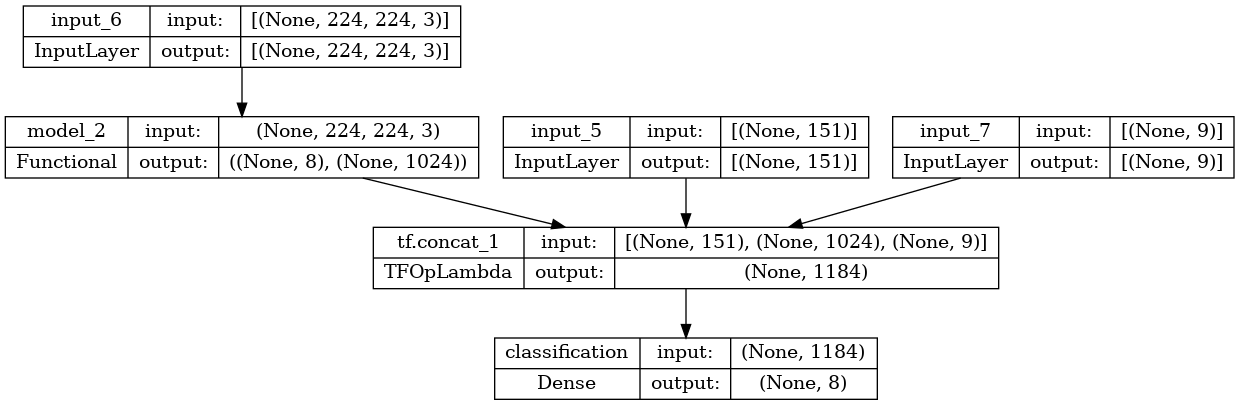

In [8]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [10]:
checkpoint = ModelCheckpoint('MobileNet_CNN+Sem+LF-{epoch:03d}-{accuracy:03f}.h5', verbose=1, 
                        monitor='accuracy',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [ ]:
history = model.fit((train_semanticfeatures,train_data,train_lowfeatures), train_labels,
            batch_size = BATCH_SIZE,
            epochs= 100, 
            callbacks= [checkpoint]
            )

history = pd.DataFrame(history.history)